# *grama* Model-Building Demo

---

*grama* is a *grammar of model analysis*---a language for describing and analyzing mathematical models. Heavily inspired by [ggplot](https://ggplot2.tidyverse.org/index.html), `py_grama` is a Python package that implements *grama* by providing tools for defining and exploring models. 

This notebook illustrates how one can use *grama* to ___build a fully-defined model___.

Note that you will need to install `py_grama`, a fork of `dfply`, and dependencies in order to run this notebook. See the [installation instructions](https://github.com/zdelrosario/py_grama) for details. 

In [1]:
### Setup
from dfply import *
import grama as gr
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

filename_stang = "stang.csv"


# Overview

---

To demonstrate building a *grama* model, we will build a plate buckling model accounting for variable material properties and uncertain loads. A *grama* model has both functions and distributions. We recommend first choosing the relevant functions, identifiying all their inputs (variables), determining which are deterministic or random, then choosing a distribution. We illustrate all of these steps below.

Note: I make no claim that the modeling choices below are optimal or even imitable; this document is primarily a demonstration of ***a fully reproducible model-building exercise***. Since all choices made here (bad or good) are documented, the resulting model's provenance is easily traceable.


# Function

---


Peery [1] gives a simple model for the buckling stress of a plate under compression

$$\sigma_{\text{buckle}} = \frac{12E}{\pi} \frac{(t/h)^2}{1 - \mu^2},$$

where

| Symbol | Variable |
|-----|-----------|
| $t$ | Thickness |
| $h$ | Height |
| $E$ | Elasticity |
| $\mu$ | Poisson's ratio |
| $\sigma_{\text{buckle}}$ | Buckling stress |

We formulate this as a reliability problem by additionally considering the imposed load $L$. To compute stress, we need the width of the plate $w$ as well; vis. $\sigma = L / t / w$. Then the *limit state* is given by

$$g_{\text{buckle}} = \sigma_{\text{buckle}} - \frac{L}{t w}.$$

This function is encoded below.


In [2]:
def function_buckle_state(x):
    t, h, w, E, mu, L = x
    return np.pi * E / 12 / (1 - mu**2) * (t / h)**2 - L / t / w

buckle_vars = ["t", "h", "w", "E", "mu", "L"]

This is the only function we consider, so we now have the full list of variables for the model.


# Variables

---

Now that we have a full list of variables, we must decide which are *random* and which are *deterministic*.

| Var | Type  | Rationale |
|-----|-------|-----------|
| $t$ | `det` | Chosen |
| $h$ | `det` | Chosen |
| $w$ | `det` | Chosen |
| $E$ | `rand` | Material property |
| $\mu$ | `rand` | Material property |
| $L$ | `rand` | Uncertain conditions |

In this study we choose $t,h,w$ to be deterministic. If we were interested in comparing manufacturing variability with other sources of uncertainty, we would need to make them random.

### Deterministic Bounds

While not required, it is helpful to give deterministic bounds for the inputs. This provides the user some context on what values are relevant to the problem at hand.

In [3]:
t_bounds = [0.125, 0.5]
h_bounds = [10, 12]
w_bounds = [2, 3]

### Random Variables

Since we have random variables, we must fit a *distribution* to describe their randomness. This ideally results from a principled, data-driven analysis. We provide an example of such a study below.

# Distribution

---

## Choosing Marginals with EDA

The following data describe the elasticity `E` and Poisson ratio `mu` of an aluminum alloy, tested at different angles [2]. First we load and inspect the data.


In [4]:
df_stang = pd.read_csv(filename_stang)
df_stang


,thick,E_00,mu_00,E_45,mu_45,E_90,mu_90,alloy
0,0.022,10600,0.321,10700,0.329,10500,0.310,al_24st
1,0.022,10600,0.323,10500,0.331,10700,0.323,al_24st
2,0.032,10400,0.329,10400,0.318,10300,0.322,al_24st
3,0.032,10300,0.319,10500,0.326,10400,0.330,al_24st
4,0.064,10500,0.323,10400,0.331,10400,0.327,al_24st
5,0.064,10700,0.328,10500,0.328,10500,0.320,al_24st
6,0.081,10000,0.315,10000,0.320,9900,0.314,al_24st
7,0.081,10100,0.312,9900,0.312,10000,0.316,al_24st
8,0.081,10000,0.311,-1,-1.000,9900,0.314,al_24st


These data were taken at different angles, and for specimens of different thicknesses. Below I [tidy](https://vita.had.co.nz/papers/tidy-data.pdf) the data in order to study the `E, mu` observations across different settings.


In [5]:
df_obs = \
    df_stang >> \
    gather("_", "E", contains("E_")) >> \
    gather("_", "mu", contains("mu_")) >> \
    select(X.thick, X.alloy, X.E, X.mu) >> \
    mask(X.E >= 0, X.mu >= 0)
df_obs.describe()


,thick,E,mu
count,76.000000,76.000000,76.000000
mean,0.051395,10344.736842,0.321461
std,0.024349,260.458435,0.006582
min,0.022000,9900.000000,0.310000
25%,0.032000,10075.000000,0.315750
50%,0.064000,10400.000000,0.322000
75%,0.081000,10500.000000,0.328000
max,0.081000,10700.000000,0.331000


We inspect the bivariate relation between `E,mu` to assess dependence and choose marginals.

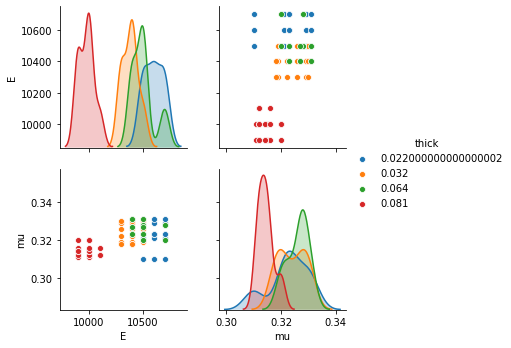

In [6]:
sns.pairplot(df_obs, vars=["E", "mu"], hue="thick")


The thickest plates seem to be quite different from the others. I would be inclied to return to [2] and see if anything was strange about these thickest samples.

If we remove the largest plates, do the marginals look closer to standard distributions?

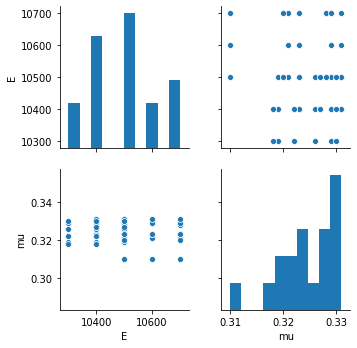

In [7]:
sns.pairplot(df_obs >> mask(X.thick < 0.08), vars=["E", "mu"])


With filtered thick plates `E` looks roughly normal. Values of Poisson ratio `mu` are extremely constrained and essentially have compact support; I choose to fit a beta distribution.


## Fitting Marginals

Now that we have selected marginal shapes, we can use the data to fit parameters for the marginals.

In [8]:
mu_a, mu_b, mu_loc, mu_scale = sp.stats.beta.fit(df_obs.mu)
mu_param = {"dist": "beta", "a": mu_a, "b": mu_b, "loc": mu_loc, "scale": mu_scale}
mu_param

{'dist': 'beta',
 'a': 1.0039169802901415,
 'b': 0.8622566703946664,
 'loc': 0.30940522475954296,
 'scale': 0.021594775240457057}

In [9]:
df_fit = df_obs >> summarize(E_mu=mean(X.E), E_sd=sd(X.E))

E_mu = df_fit["E_mu"].values[0]
E_sd = df_fit["E_sd"].values[0]

df_fit

,E_mu,E_sd
0,10344.736842,260.458435


Lastly, we need to choose a distribution for the uncertain load. We have no data available, so this will have to be by choice. I selected the values below to lead to a small probability of `g_buckle` going negative.

In [10]:
L_mu = 0.8
L_s = 0.01

# `py_grama` Model Definition

---

With the information above, we can build our `py_grama` model.

In [11]:
md_plate = \
    gr.Model("Plate Buckling") >> \
    gr.cp_function(
        fun=function_buckle_state,
        var=buckle_vars,
        out=["g_buckle"]
    ) >> \
    gr.cp_bounds(
        t=t_bounds,
        w=w_bounds,
        h=h_bounds
    ) >> \
    gr.cp_marginals(
        E={"dist": "norm", "loc": E_mu, "scale": E_sd},
        mu=mu_param,
        L={"dist": "lognorm", "loc": 1, "s": L_s, "scale": L_mu, "sign": +1}
    )

md_plate.printpretty()


model: Plate Buckling

  inputs:
    var_det:
      t: [0.125, 0.5]
      h: [10, 12]
      w: [2, 3]
    var_rand:
      E: (+0) norm, {'loc': 10344.736842105263, 'scale': 260.4584352468318}
      mu: (+0) beta, {'a': 1.0039169802901415, 'b': 0.8622566703946664, 'loc': 0.30940522475954296, 'scale': 0.021594775240457057}
      L: (+1) lognorm, {'loc': 1, 's': 0.01, 'scale': 0.8}
  functions:
    function_buckle_state: ['t', 'h', 'w', 'E', 'mu', 'L'] -> ['g_buckle']


The method `printpretty()` allows us to summarize the model. We can check that the correct variables are sorted into deterministic (`det`) or random (`rand`) categories, and that the correct distributions and parameters are assigned for each marginal.

With a fully defined model, we can carry out various kinds of model analyses, for instance a Monte Carlo analysis is not a one-line call. The [analysis demo](https://github.com/zdelrosario/py_grama/blob/master/examples/demo/analysis_demo.ipynb) has more details on model analysis with `py_grama`.

In [12]:
df_mc = md_plate >> gr.ev_monte_carlo(n=1e3, df_det="nom")
df_mc.describe()

,E,mu,L,t,h,w,g_buckle
count,1000.000000,1000.000000,1000.000000,1000.0000,1000.0,1000.0,1000.000000
mean,10335.340667,0.321482,1.800159,0.3125,11.0,2.5,0.131432
std,261.785521,0.006292,0.008018,0.0000,0.0,0.0,0.063398
min,9644.797535,0.309419,1.773338,0.3125,11.0,2.5,-0.054348
25%,10160.455057,0.316318,1.794953,0.3125,11.0,2.5,0.088690
50%,10342.966902,0.322087,1.800284,0.3125,11.0,2.5,0.131562
75%,10499.662963,0.326985,1.805295,0.3125,11.0,2.5,0.175013
max,11177.435188,0.330991,1.827226,0.3125,11.0,2.5,0.340001


# Bibliography

---

[1] David J Peery. Aircraft structures. Courier Corporation, 2011.

[2] A. H. Stang, M. Greenspan, and S. B. Newman, Journal of Research of the National Bureau of Standards 37, (1946).
